In [1]:
import xupy as xp
import matplotlib.pyplot as plt

from ekarus.e2e.single_stage_ao_class import SingleStageAO
# from ekarus.e2e.devices.alpao_deformable_mirror import ALPAODM

from ekarus.e2e.utils.image_utils import reshape_on_mask

from ekarus.analytical.kl_modes import make_modal_base_from_ifs_fft

from numpy.ma import masked_array
from ekarus.analytical.zernike_generator import ZernikeGenerator


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
def create_field_from_zernike_coefficients(mask, noll_ids, amplitudes):
    """
    Create an electric field input corresponding to a Zernike aberration.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: input electric field as a numpy complex array
    """
    phase_mask = project_zernike_on_mask(mask, noll_ids, amplitudes)
    return (1-mask) * xp.exp(1j * phase_mask)


def project_zernike_on_mask(mask, noll_ids, amplitudes):
    """
    Create a linear combination of Zernikes on a mask.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: zernike combination
    """
    mask_size = max(mask.shape)
    zg = ZernikeGenerator(xp.asnumpy(mask),mask_size//2)

    if isinstance(noll_ids,int):
        amp = amplitudes
        noll = noll_ids
        zern = amp * xp.asarray(zg.getZernike(int(noll)))
    else:
        amplitudes *= xp.ones_like(noll_ids)
        zern = xp.zeros(mask.shape)
        for amp,noll in zip(amplitudes, noll_ids):
            zern += amp * xp.asarray(zg.getZernike(int(noll)))

    return zern

In [3]:
ssao = SingleStageAO(tn='master_single_stage')
ssao.initialize_turbulence()
ssao.pyr.set_modulation_angle(ssao.sc.modulationAngleInLambdaOverD)
KL, m2c = ssao.define_KL_modes(ssao.dm, zern_modes=5)

Initializing devices ...
Fried parameter is: 5.5 [cm] (seeing = 1.85")
Modulating 3 [lambda/D] with 20 modulation steps


Initializing devices ...
Unobscured actuators: 752/820
Fried parameter is: 5.5 [cm] (seeing = 1.85")
Modulating 3 [lambda/D] with 20 modulation steps


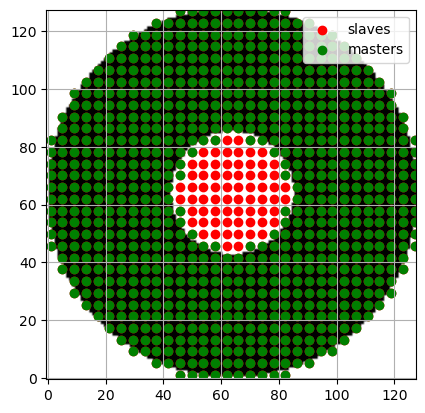

In [4]:
slav_ssao = SingleStageAO(tn='slaving_single_stage')
slav_ssao.initialize_turbulence()
slav_ssao.pyr.set_modulation_angle(slav_ssao.sc.modulationAngleInLambdaOverD)
sKL, sm2c = slav_ssao.define_KL_modes(slav_ssao.dm, zern_modes=5)

In [5]:
sdm = slav_ssao.dm
anular_mask = slav_ssao.cmask.copy()
IFFs = slav_ssao.dm.IFF[slav_ssao.dm.visible_pix_ids,:].T
filtKL, filt_m2c, _ = make_modal_base_from_ifs_fft(pupil_mask=1-anular_mask, diameter=slav_ssao.pupilSizeInM, pupil_pix_radius=slav_ssao.pupilSizeInPixels,
                                      influence_functions=IFFs,r0=55e-3,L0=25,zern_modes=5,oversampling=4,xp=xp,dtype=xp.float32,
                                      if_max_condition_number=100,verbose=True)

Starting modal basis generation...
Input shapes: pupil_mask=(128, 128), influence_functions=(820, 11416)
Step 1: Removing modes from influence functions...
Generated Zernike modes shape: (5, 128, 128)
Step 2: Calculating geometric covariance matrix...
Step 3: SVD decomposition of covariance matrix...
-- IF covariance matrix SVD ---
    initial condition number is: 8254732.5
    final condition number is: 27.51676368713379
    no. of cut modes: 68
Step 4: Calculating turbulence covariance matrix...
Computing turbulence covariance matrix...
Step 1: Computing Fourier transforms of influence functions...
Step 2: Generating phase spectrum and computing covariance matrix...
Step 3: Computing covariance matrix in Fourier domain...
Step 4: Computing covariance matrix in spatial domain...
Step 5: Calculating modal basis...
Step 6: Adding Zernike modes to basis...
Final shapes: kl_basis=(751, 11416), m2c=(820, 751)


In [6]:
IM = xp.linalg.pinv(m2c @ KL)
sIM = xp.linalg.pinv(sm2c @ sKL)
fIM = xp.linalg.pinv(filt_m2c @ filtKL)

U,S,V = xp.linalg.svd(IM,full_matrices=False)
sU,sS,sV = xp.linalg.svd(sIM,full_matrices=False)
fU,fS,fV = xp.linalg.svd(fIM,full_matrices=False)

Rec = (V.T * 1/S) @ U.T
sRec = (sV.T * 1/sS) @ sU.T
filtRec = (fV.T * 1/fS) @ fU.T

# plt.figure()
# plt.plot(xp.asnumpy(1/S),'o',label='full')
# plt.plot(xp.asnumpy(1/sS),'o',label='slaved')
# plt.plot(xp.asnumpy(1/fS),'o',label='filtered')
# plt.grid()
# plt.legend()

Text(0.5, 1.0, 'Reduction matrix')

<Figure size 640x480 with 0 Axes>

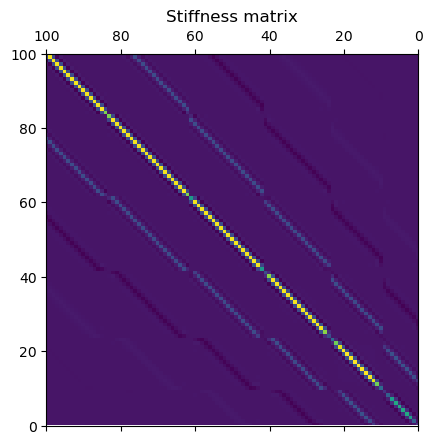

<Figure size 640x480 with 0 Axes>

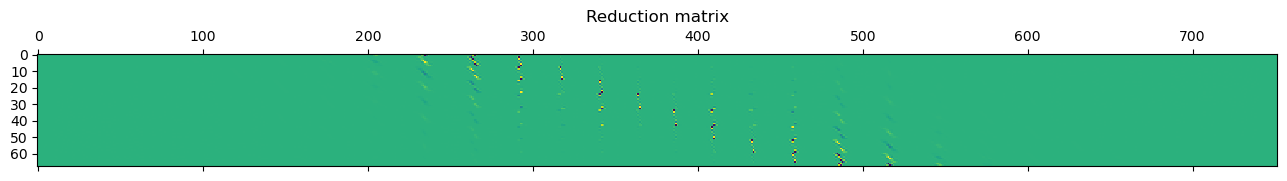

In [7]:
# Riccardi's slaving
IF = sdm.IFF.copy()
K = IF.T @ IF
master_ids = sdm.master_ids
slave_ids = xp.arange(sdm.Nacts)
is_slave = xp.ones(sdm.Nacts,dtype=bool)
is_slave[master_ids] = 0
slave_ids = slave_ids[is_slave]

Km = K[master_ids,:]
Ks = K[slave_ids,:]
Kmm = Km[:,master_ids]
Kms = Km[:,slave_ids]
Ksm = Ks[:,master_ids]
Kss = Ks[:,slave_ids]

A = Kms.T @ Kms + Kss.T @ Kss
B = Kms.T @ Kmm + Kss.T @ Ksm
Qs = -xp.linalg.inv(A) @ B

plt.figure()
plt.matshow(xp.asnumpy(K))
plt.title('Stiffness matrix')
plt.axis([100,0,0,100])

plt.figure()
plt.matshow(xp.asnumpy(Qs))
plt.title('Reduction matrix')

In [8]:
IM = xp.linalg.pinv(m2c @ KL)

IMm = IM[:,master_ids]
IMs = IM[:,slave_ids]

newIM = IMm + IMs @ Qs

IFm = IF[:,master_ids]
IFs = IF[:,slave_ids]

newIF = IFm + IFs @ Qs

print(KL.shape,newIM.shape)

newRec = xp.linalg.pinv(newIF)


(819, 12849) (12849, 752)


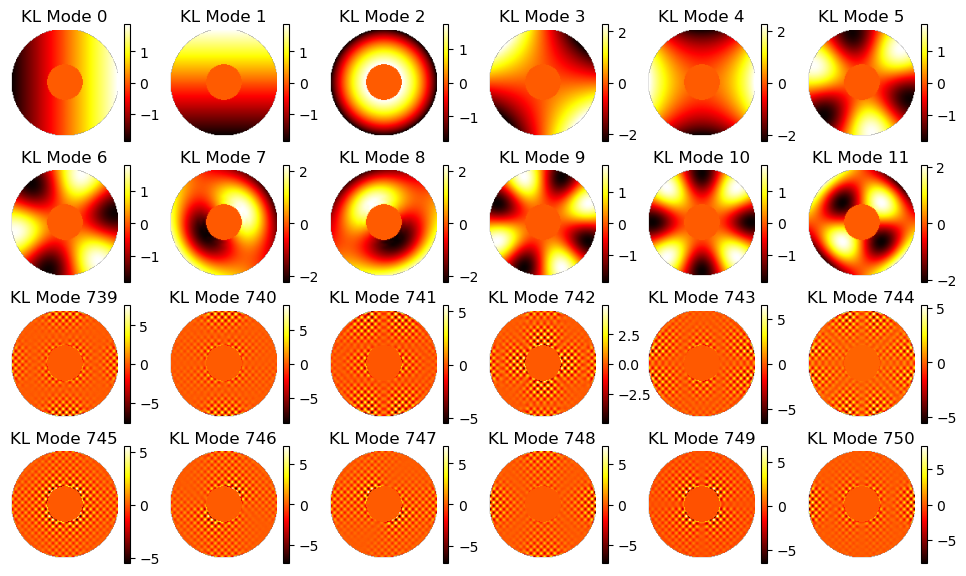

In [9]:
N=6
plt.figure(figsize=(2*N,7))
for i in range(N):
    plt.subplot(4,N,i+1)
    sdm.plot_surface(filtKL[i,:],title=f'KL Mode {i}')
    plt.subplot(4,N,i+1+N)
    sdm.plot_surface(filtKL[i+N,:],title=f'KL Mode {i+N}')
    plt.subplot(4,N,i+1+N*2)
    sdm.plot_surface(filtKL[-i-1-N,:],title=f'KL Mode {xp.shape(filtKL)[0]-2*N+i}')
    plt.subplot(4,N,i+1+N*3)
    sdm.plot_surface(filtKL[-i-1,:],title=f'KL Mode {xp.shape(filtKL)[0]-N+i}')

In [10]:
def get_lsq_rec(KL, m2c, visible_ids, penalty:float=1e-4, modal:bool=False):
    lambdas = xp.zeros(sdm.Nacts)
    lambdas[is_slave] = penalty
    LAMBDA = xp.diag(lambdas)
    IM = KL.T @ xp.linalg.pinv(m2c) #m2c @ xp.linalg.pinv(KL.T)
    IMm = IM[visible_ids,:]
    aux = xp.linalg.pinv(IMm.T @ IMm + LAMBDA)
    newRec = aux @ IMm.T
    if modal:
        newRec = xp.linalg.pinv(m2c) @ newRec
    return newRec

In [11]:
def get_tichonov_rec(KL, m2c, visible_ids, gamma:float=1e-4, modal:bool=False):
    IM = KL.T @ xp.linalg.pinv(m2c) #m2c @ xp.linalg.pinv(KL.T)
    IMm = IM[visible_ids,:]
    U,S,V = xp.linalg.svd(IMm,full_matrices=False)
    Sinv = 1/S
    LAMBDA = S**2/(gamma+S**2) * Sinv
    LAMBDA[S/max(S)>gamma] = Sinv[S/max(S)>gamma]
    # plt.figure()
    # plt.plot(xp.asnumpy(Sinv))
    # plt.plot(xp.asnumpy(LAMBDA))
    # plt.grid()
    # plt.xscale('log')
    # plt.yscale('log')
    newRec = (V.T * LAMBDA) @ U.T
    if modal:
        newRec = xp.linalg.pinv(m2c) @ newRec
    return newRec

In [12]:
print((KL.T @ xp.linalg.pinv(m2c)).shape)

(12849, 820)


Text(0.5, 1.0, 'Difference (slaving filtered)')

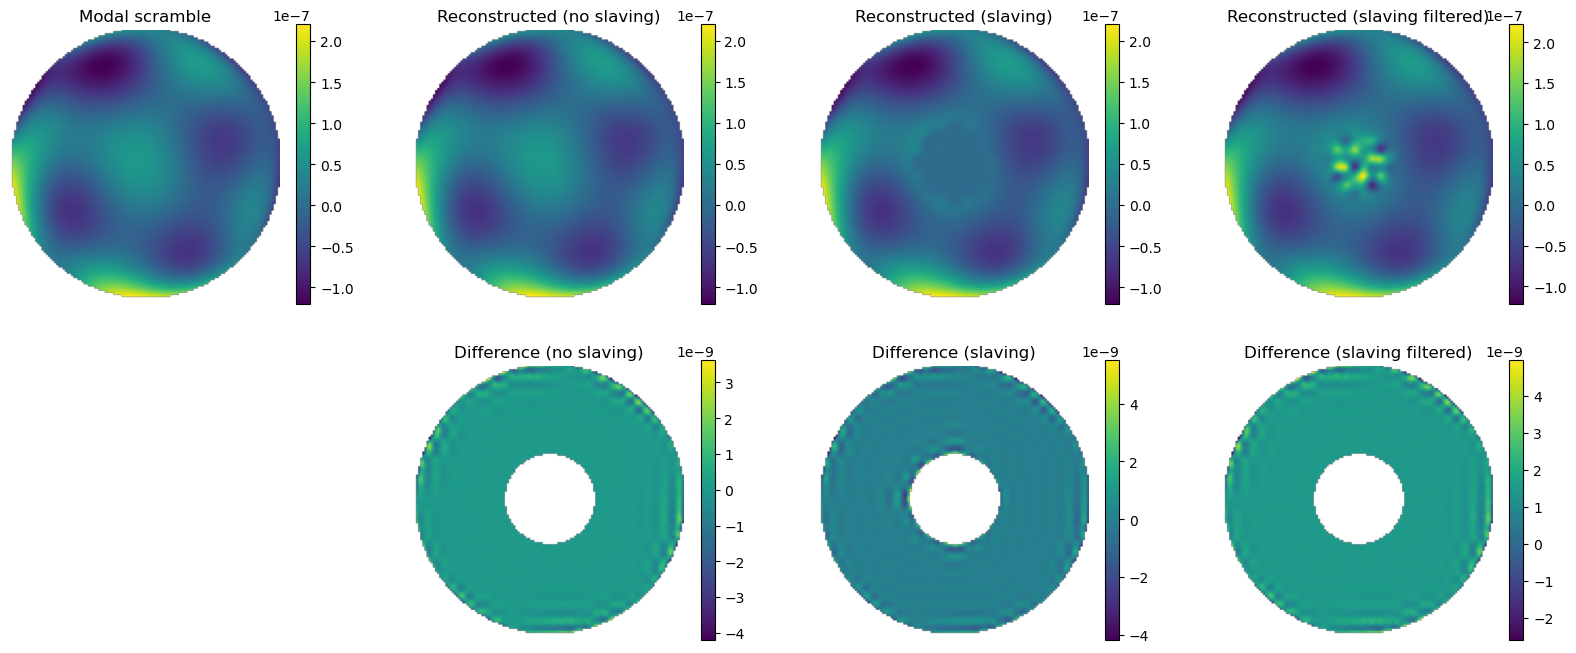

In [16]:
# modal_amps = xp.random.randn(sdm.Nacts)
# modal_scramble = IF @ modal_amps
# mode_phase = reshape_on_mask(modal_scramble, ssao.cmask)

zern_ids = xp.arange(2,28,dtype=int)
zern_amps = xp.random.randn(len(zern_ids))*1e-8
zern_order = xp.maximum(1,xp.round(xp.sqrt(zern_ids)))
mode_phase = project_zernike_on_mask(ssao.cmask, zern_ids, zern_amps)

# cmd_scramble = xp.zeros(sdm.Nacts)
# cmd_scramble[sdm.master_ids] = xp.random.randn(len(sdm.master_ids))*1e-8
# dm_shape = sdm.IFF @ cmd_scramble
# mode_phase = reshape_on_mask(dm_shape, ssao.cmask)


modal_scramble = mode_phase[~ssao.cmask]

Rec = xp.linalg.pinv(IF)
IFv = IF[sdm.visible_pix_ids,:]
sRec = xp.linalg.pinv(IFv[:,master_ids])


rec_cmd = Rec @ modal_scramble
rec_shape = IF @ rec_cmd
rec_phase = reshape_on_mask(rec_shape, ssao.cmask)

slav_rec_cmd = sRec @ modal_scramble[sdm.visible_pix_ids]
rec_shape = IF[:,master_ids] @ slav_rec_cmd
srec_phase = reshape_on_mask(rec_shape, ssao.cmask)

# filt_rec_cmd = filtRec @ modal_scramble[sdm.visible_pix_ids]
# rec_shape = IF @ filt_rec_cmd
# frec_phase = reshape_on_mask(rec_shape, ssao.cmask)

# newRec = get_lsq_rec(KL,m2c,sdm.visible_pix_ids,1e-3)
newRec = get_tichonov_rec(KL,m2c,sdm.visible_pix_ids,4e-4)

# rec_modes = newRec @ modal_scramble[sdm.visible_pix_ids]
# rec_cmd = m2c @ rec_modes
rec_cmd = newRec @ modal_scramble[sdm.visible_pix_ids]
rec_shape = IF @ rec_cmd
frec_phase = reshape_on_mask(rec_shape, ssao.cmask)

# newRec = m2c @ xp.linalg.pinv(KL.T)
# newIM = xp.linalg.pinv(newRec)
# rec_shape = newIM @ modal_amps
# # rec_cmd = newRec @ modal_scramble
# # rec_shape = IF @ rec_cmd
# frec_phase = reshape_on_mask(rec_shape, ssao.cmask)

plt.figure(figsize=(20,8))
plt.subplot(2,4,1)
plt.imshow(masked_array(xp.asnumpy(mode_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower')
plt.colorbar()
plt.axis('off')
plt.title('Modal scramble')
plt.subplot(2,4,2)
plt.imshow(masked_array(xp.asnumpy(rec_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed (no slaving)')
plt.subplot(2,4,3)
plt.imshow(masked_array(xp.asnumpy(srec_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed (slaving)')
plt.subplot(2,4,6)
plt.imshow(masked_array(xp.asnumpy(mode_phase-rec_phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower')
plt.colorbar()
plt.axis('off')
plt.title('Difference (no slaving)')
plt.subplot(2,4,7)
plt.imshow(masked_array(xp.asnumpy(mode_phase-srec_phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower')
plt.colorbar()
plt.axis('off')
plt.title('Difference (slaving)')
plt.subplot(2,4,4)
plt.imshow(masked_array(xp.asnumpy(frec_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed (slaving filtered)')
plt.subplot(2,4,8)
plt.imshow(masked_array(xp.asnumpy(mode_phase-frec_phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower')
plt.colorbar()
plt.axis('off')
plt.title('Difference (slaving filtered)')

# plt.figure()
# plt.plot(xp.asnumpy(modal_amps),'o',label='true')
# plt.plot(xp.asnumpy(rec_amps),'*',label='reconstructed')
# plt.plot(xp.asnumpy(slav_rec_amps),'+',label='slaved')
# plt.legend()
# plt.grid()